In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install keras
# !pip install -U scikit-learn scipy matplotlib

Loading word vectors...
Found 400000 word vectors.
Loading in comments...
max sequence length: 5000
min sequence length: 6
median sequence length: 205
Found 210337 unique tokens.
Shape of data tensor: (159571, 100)
Filling pre-trained embeddings...
Building model...
Training model...
Epoch 1/10
998/998 [==============================] - 33s 32ms/step - loss: 0.0861 - accuracy: 0.9834 - val_loss: 0.0724 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0681 - accuracy: 0.9941 - val_loss: 0.0674 - val_accuracy: 0.9940
Epoch 3/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0629 - accuracy: 0.9931 - val_loss: 0.0674 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0591 - accuracy: 0.9939 - val_loss: 0.0744 - val_accuracy: 0.9928
Epoch 5/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0555 - accuracy: 0.9935 - val_loss: 0.0758 - val_accuracy: 0.

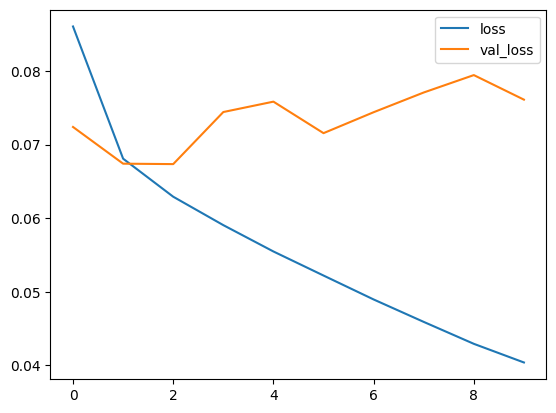

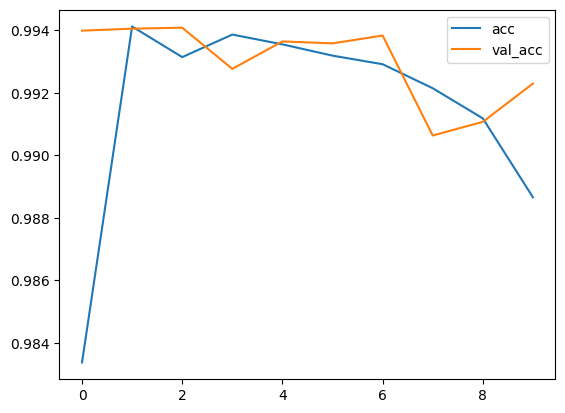

4987/4987 [==============================] - 16s 3ms/step
0.9843791886482035


In [7]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of futrure
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip


# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10




# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf8') as f:
    # is just a space-separated text file in the format
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("./train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]
targets = train[possible_labels].values

print("max sequence length:", max(len(s) for s in sentences))
print("min sequence length:", min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s) // 2])




# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)



# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeroes.
            embedding_matrix[i] = embedding_vector



# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))